In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define transformations for dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Load datasets
train_set = ImageFolder('/home/vaishnavi/JupyterNoteboook/train', transform)
test_set = ImageFolder('/home/vaishnavi/JupyterNoteboook/test', transform)

print("Train", len(train_set))
print("Test", len(test_set))

tensor_img, label = train_set[0]
print(tensor_img.shape)
print(label)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)




Train 1275
Test 182
torch.Size([3, 28, 28])
0


In [2]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 11 * 11, 2),
        )

    def forward(self, x):
        return self.model(x)

In [3]:
# Training function
def fit(clf, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        clf.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()           # Zero the gradients
            outputs = clf(inputs)          # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()                # Compute gradients
            optimizer.step()               # Update parameters
            
            train_loss += loss.item() * inputs.size(0)  # Accumulate loss
            pred = torch.argmax(outputs, 1) # Get the index of the predicted class
            train_correct += torch.sum(pred == labels.data)  # Count correct predictions
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct.double() / len(train_loader.dataset)
        
        # Validation
        clf.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0 
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = clf(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, 1)
                val_correct += torch.sum(pred == labels.data)
        
        val_loss /= len(test_loader.dataset)
        val_acc = val_correct.double() / len(test_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# Initialize model, loss function, and optimizer
clf = CNN()
LossFunc = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.001)

# Train the model
fit(clf, train_loader, test_loader, LossFunc, optimizer, epochs=5)
        

Epoch 1/5 - Training Loss: 0.6383, Train Accuracy: 0.6439, Validation Loss: 0.5745, Validation Accuracy: 0.7802
Epoch 2/5 - Training Loss: 0.5682, Train Accuracy: 0.6980, Validation Loss: 0.4720, Validation Accuracy: 0.8077
Epoch 3/5 - Training Loss: 0.4954, Train Accuracy: 0.7788, Validation Loss: 0.4930, Validation Accuracy: 0.7747
Epoch 4/5 - Training Loss: 0.4567, Train Accuracy: 0.8000, Validation Loss: 0.4848, Validation Accuracy: 0.7912
Epoch 5/5 - Training Loss: 0.4526, Train Accuracy: 0.7945, Validation Loss: 0.4705, Validation Accuracy: 0.7857


In [4]:

# Accuracy evaluation
def evaluate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate and print accuracy
test_accuracy = evaluate_accuracy(clf, test_loader)
print(f'Accuracy of the model on the test dataset: {test_accuracy:.2f}%')

Accuracy of the model on the test dataset: 78.57%


Predicted class: Daisy


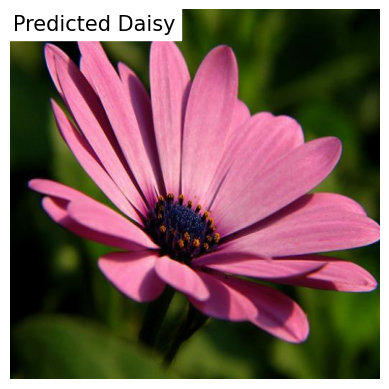

In [5]:

# Prediction for a sample image
classes = ["Daisy", "Dandelion"]
path = "/home/vaishnavi/JupyterNoteboook/test/daisy/1342002397_9503c97b49_jpg.rf.8fe6bdd23186b70f089bb0c5b89d314e.jpg"
image = Image.open(path)
image_tensor = transform(image)
img = image_tensor.unsqueeze(0)

with torch.no_grad():
    pred = clf(img)

pred_index = pred.argmax(1)
pred_class = classes[pred_index.item()]
print(f"Predicted class: {pred_class}")

# Display image with prediction
image_np = np.array(image)
plt.axis("off")
plt.text(4, 28, f"Predicted {pred_class}", fontsize=15, backgroundcolor="white")
plt.imshow(image_np)
plt.show()

In [7]:
# Save the model
torch.save(clf.state_dict(), 'model.pth')


In [8]:
model_path = 'model.pth'

try:
    torch.save(clf.state_dict(), model_path)
    print(f"Model successfully saved to {model_path}")
except Exception as e:
    print(f"Error saving model: {e}")

Model successfully saved to model.pth
